# Eigenpair Flow Demonstration

This notebook demonstrates the use of the `eigenpairflow` library to track the eigenvalues and eigenvectors of a one-parameter family of symmetric matrices $A(t)$.

## Mathematical Background

Given a one-parameter family of symmetric matrices $A(t)$, we consider its eigenvalue decomposition:
$$ A(t) = Q(t) \Lambda(t) Q(t)^T $$
where $Q(t)$ is an orthogonal matrix of eigenvectors and $\Lambda(t)$ is a diagonal matrix of eigenvalues.

By differentiating the equation $A(t)Q(t) = Q(t)\Lambda(t)$, we can derive a system of ordinary differential equations (ODEs) for $Q(t)$ and $\Lambda(t)$. The core equation for the derivatives is:
$$ F(t) = \frac{d\Lambda}{dt} + [H(t), \Lambda(t)] $$
where $F(t) = Q(t)^T \frac{dA}{dt} Q(t)$ and $H(t) = Q(t)^T \frac{dQ}{dt}$ is a skew-symmetric matrix.

The `eigenpairflow` library solves this system of ODEs to track the continuous evolution of eigenvalues and eigenvectors.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Import the main tracking function and result type
from eigenpairflow import eigenpairtrack, EigenTrackingResults

# Import application-specific helpers for graph creation and magnitude analysis
from eigenpairflow.graph import create_n_partite_graph
from eigenpairflow.magnitude import (
    calculate_magnitudes,
    calculate_pseudo_magnitudes,
    get_zero_indices,
    plot_magnitudes,
)
from eigenpairflow.visualization import plot_tracking_results

In [2]:
# --- 1. Define the Problem: A Matrix Function from a Graph ---

# Create an n-partite graph using a helper function
partition_sizes = [3, 2, 1, 1, 4, 2]
lengths = {
    (0, 1): 3.0,
    (1, 2): 1.5,
    (2, 3): 0.1,
    (3, 4): 1.0,
    (4, 5): 3.5,
}
G = create_n_partite_graph(partition_sizes, lengths)

# Compute the graph's distance matrix D
D = np.array(nx.floyd_warshall_numpy(G, weight="length"))

# Define the one-parameter matrix function A(t) and its derivative
def A_func(t):
    return np.exp(-t * D)

def dA_func(t):
    return -D * np.exp(-t * D)

In [3]:
# --- 2. Run the Eigenpair Tracking ---

# Define the time interval and evaluation points
t_start, t_end = 4.0, 1.0e-2
t_eval = np.geomspace(t_start, t_end, 10000)

# Call the main tracking function
print("--- Starting tracking and analysis ---")
results = eigenpairtrack(
    A_func, 
    dA_func, 
    (t_start, t_end), 
    t_eval, 
    matrix_type="symmetric", 
    method="eigh", 
    apply_correction=True
)

if not results.success:
    print(f"Tracking failed: {results.message}")
else:
    print("Tracking completed successfully.")

--- Starting tracking and analysis ---


Tracking completed successfully.


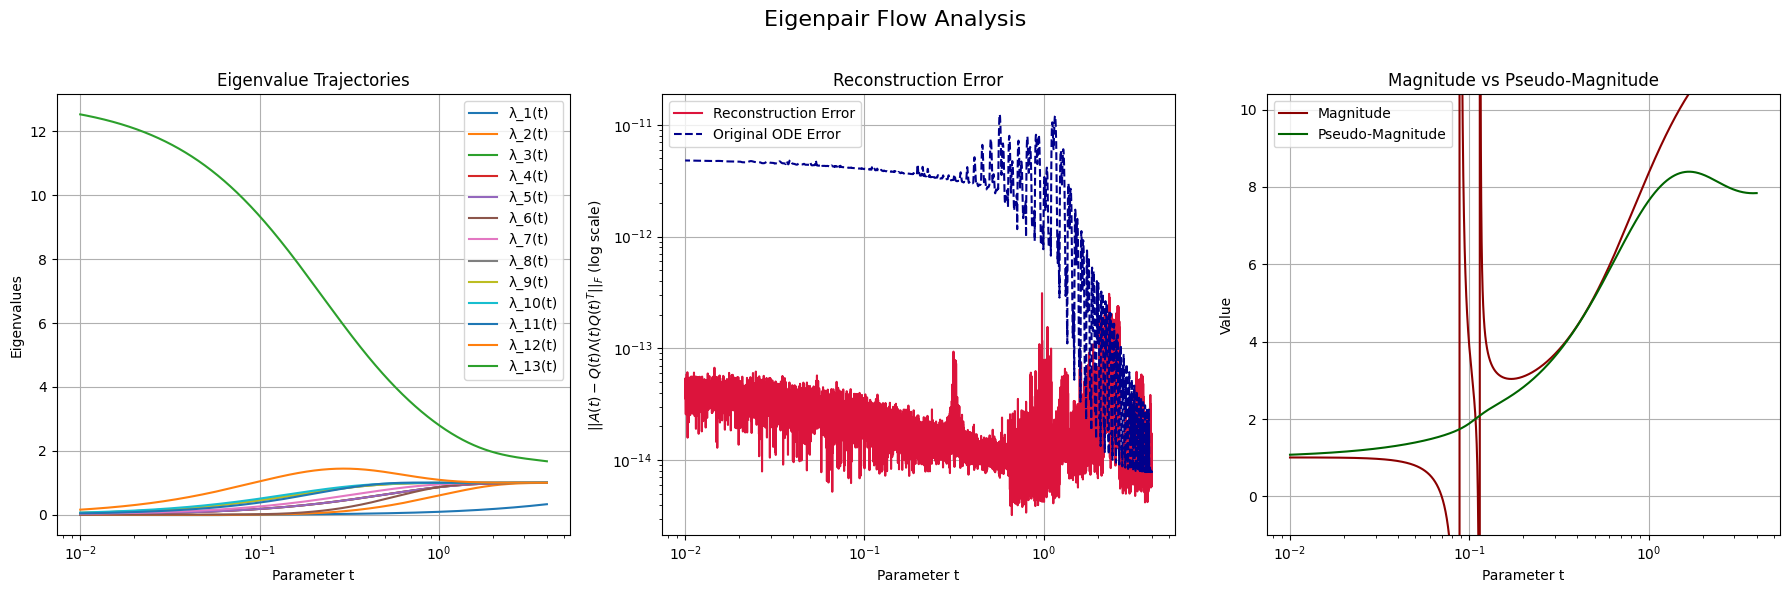

In [4]:
# --- 3. Post-processing and Visualization ---
if results.success:
    # Perform application-specific analysis (magnitude calculation)
    zero_indices = get_zero_indices(results.Lambdas)
    magnitudes = calculate_magnitudes(results.Qs, results.Lambdas, D)
    pseudo_magnitudes = calculate_pseudo_magnitudes(
        results.Qs, results.Lambdas, D, zero_indices
    )

    # Create a combined plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot the generic tracking results (eigenvalue trajectories and error)
    plot_tracking_results(results, axes=axes[0:2])
    
    # Plot the application-specific magnitude results
    plot_magnitudes(results.t_eval, magnitudes, pseudo_magnitudes, ax=axes[2])
    
    fig.suptitle("Eigenpair Flow Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()